# 本文件说明
- 训练模型,查看模型结果：包括K-fold、概率结果

# 基本设置

In [2]:
import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [8]:
# from toolkits.nlp.generate_keywords import generate_keywords
import myclass_circ
import load_save_plot_file

In [4]:
%load_ext autoreload
%autoreload 2

## 一些函数

In [5]:
def cal_kfold(title_content, label, pipeline, raw_folder, filename, class_name_dict):
    from sklearn.model_selection import KFold
    import numpy as np

    data_raw = pd.read_excel('%s/corpus/title_content_label.xlsx'%raw_folder)
    raw_title = np.array(data_raw['title'])
    raw_content = np.array(data_raw['content'])
    print('data_raw: ', data_raw.shape)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    title_content = np.array(title_content)
    label = np.array(label)
    
    kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 
             'predict_label':[], 'title_content':[], 'predict_proba':[]}

    num = 0
    for train_index , test_index in kf.split(title_content):
        print('---- %s'%(num+1))
        X_train,X_test = title_content[train_index], title_content[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        pipeline.fit(X_train, y_train)
        print(pipeline.score(X_train, y_train))    

        y_pred_class = pipeline.predict(X_test)
        print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
        print(metrics.classification_report(y_test, y_pred_class))
        print('confusion_matrix: ')
        print( metrics.confusion_matrix(y_test, y_pred_class))   
        
        y_pred_prob = pipeline.predict_proba(X_test)

        kfold_res['raw_title'] += list(raw_title[test_index])
        kfold_res['raw_content'] += list(raw_content[test_index])
        kfold_res['title_content'] += list(X_test)
        kfold_res['label'] += [class_name_dict[i] for i in y_test]
        kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
        kfold_res['predict_proba'] += list(y_pred_prob.max(axis = 1))
    
        num += 1
        
    kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
    kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
    print('kfold_result: ', kfold_result.shape)
    
    with pd.ExcelWriter('%s/corpus/%s'%(raw_folder, filename)) as writer:
        for label in kfold_result['label'].unique():
            tmp_data = kfold_result[kfold_result['label'] == label]
            tmp_data.to_excel(writer, label, index = False)
        writer.save()

In [6]:
def plot_class_proba(y_pred_class, y_pred_prob):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sel_data = pd.DataFrame()
    sel_data['predict_label'] = y_pred_class
    sel_data['predict_proba'] = y_pred_prob
    sel_data['label'] = y_test

    label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
    # sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
    g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False)
    g.map(plt.hist, "predict_proba", bins = 10)

    sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:round(x, 1))
    sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
    sel_data_stat['sum'] = sel_data_stat.sum(axis = 1)
    sel_data_stat.loc['sum'] = sel_data_stat.sum(axis = 0)
    return sel_data_stat

# 教育部：1 二分类

## 导入与分割数据

In [30]:
cbrc_filepath_class = 'cor_result/corpus/'
title_content, label, title, content = load_save_plot_file.title_content_label(cbrc_filepath_class)
label = [int(l) for l in label]
label[:5]

title num:  5628
['合肥 条 道路 乱 停放 共享 单车 受罚 新华网 安徽 频道', '高速路 倒车 走 错 挨罚']
content num:  5628
title_content num:  5628
label num:  5628
['1', '1', '1', '1', '1']


[1, 1, 1, 1, 1]

In [33]:
from sklearn.utils.class_weight import compute_class_weight

In [34]:
class_weight = 'balanced'
classes=[0, 1]
weight = compute_class_weight(class_weight, classes, label)
print(weight)

[3.04216216 0.59834148]


In [19]:
label_dic={'不相关':0,'相关':1}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '不相关', 1: '相关'}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 3939
训练集-各类数量： Counter({1: 3305, 0: 634})
测试集： 1689
测试集-各类数量： Counter({1: 1398, 0: 291})


## 生成词典

In [26]:
# g_k = generate_keywords(500)
# g_k.gen_keywords_by_class(title_content, label, v_thre = 3)

In [27]:
# g_k.save_txt('keywords_i.txt')

## features

In [38]:
# org = 'moe'
# model = 'class'
# date = '20181119'

In [39]:
# pipeline = Pipeline([
#     ('features', FeatureUnion([
#         ('tf_idf', Pipeline([
#             ('counts', CountVectorizer(max_df=0.95, min_df=2)),
#             ('tf_idf', TfidfTransformer()),
#             ('chi', SelectKBest(chi2, k=2000))
#         ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
#        # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
#     ])),
#     ('standard', StandardScaler(with_mean=False))
# ])

# pipeline_train = pipeline.fit(title_content, label)
# X_features = pipeline_train.transform(title_content)
# print(X_features.shape)

# from sklearn.externals import joblib
# joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
# joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
# joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

(1049, 2009)


['model/moe_class_labels_20181119.pkl.z']

In [ ]:
# from sklearn.externals import joblib
# pipeline_train = joblib.load( "model/circ_class_pipeline_20181108.pkl.z")
# X_features = joblib.load( "model/circ_class_features_20181108.pkl.z")
# label = joblib.load( "model/circ_class_labels_20181108.pkl.z")
# print(X_features.shape)
# print(len(label))

### tf

In [1]:
# from collections import Counter
# word_count = Counter(" ".join(title_content).split())
# # word_count_sel = word_count.most_common(2000)
# # word_count_sel
# # word_count

# word_count = pd.DataFrame.from_dict(word_count, orient='index' ).reset_index()
# word_count.columns = ['word', 'count']
# word_count = word_count.sort_values(by = 'count', ascending = False)
# print(word_count.shape)
# word_count_sel = word_count.iloc[:2000, :]
# print(word_count_sel.shape)
# word_count_sel.to_excel(r'cor_result\result\word_count_20181120.xlsx', index = False)
# word_count.head()

## train & test

In [28]:
# a = myclass_circ.Statskeywords_cor(5000)
# len(a.keywords)

In [45]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
       # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='binary:logistic', scale_pos_weight=0.5))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9865448083269865


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=...      reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=None,
       silent=True, subsample=1))])

In [51]:
y_pred_class = pipeline.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
print('AUC：%0.3f'%metrics.auc(fpr, tpr))
print('ACC: %0.3f'%metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

AUC：0.935
ACC: 0.967
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       291
           1       0.98      0.98      0.98      1398

   micro avg       0.97      0.97      0.97      1689
   macro avg       0.95      0.94      0.94      1689
weighted avg       0.97      0.97      0.97      1689

confusion_matrix: 
[[ 258   33]
 [  23 1375]]


In [53]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |      Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use n_jobs)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces nthread)
 |  gamma : float
 |      Minimum

## 不平衡样本

In [ ]:
import pandas as pd
# 过抽样处理库SMOTE
from imblearn.over_sampling import SMOTE 
# 欠抽样处理库RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.svm import SVC #SVM中的分类算法SVC
# 简单集成方法EasyEnsemble
from imblearn.ensemble import EasyEnsemble 

In [32]:
model_smote = SMOTE() # 建立SMOTE模型对象
x_smote_resampled, y_smote_resampled = model_smote.fit_sample(title_content, label) # 输入数据并作过抽样处理

ValueError: Expected 2D array, got 1D array instead:
array=['合肥 条 道路 乱 停放 共享 单车 受罚 新华网 安徽 频道 记者 日前 合肥市 庐阳区 城 管委 获悉 庐阳区 划定 北 环路 长江中路 两条路 首批 共享 单车 严管 路段 含 山路 环城路 条 道路 共享 单车 禁停 路段 禁停 路段 发现 乱 停放 共享 单车 庐阳区 城 管委 督促 单车 企业 分钟 清运 拖移 处置 后期 用户 违停 收到 单车 平台 提醒 收取 调度 费 扣取 信用 分 影响 后续 用车 条 路段 为北 环路 长江中路 含 山路 环城路 宿州 路 可苑 路 茨 河路 义井路 一步 庐阳区 城 管委 督促 单车 企业 利用 电子 围栏 定位 技术 平台 显示 禁停 路段 庐阳区 城 管委 负 用户 执意 挪车 各家 单车 企业 收取 调度 费 扣取 信用 分 影响 后续 用车 希望 正面 清单 负面 清单 相结合 停放 管理模式 培养 市民 停车 习惯 维护 出行 环境'
 '高速路 倒车 走 错 挨罚 高速公路 倒车 危险 举动 近日 高 警局 湘潭 支队 民警 沪 昆 高速 东往 西 公里 塔岭 互通 处 路面 监控 抓拍 高速公路 行车道 停车 倒车 违法行为 事后 驾驶员 发现 危险 倒车 受罚 走 错 路 高 警局 湘潭 支队 湘潭 大队 民警 肖志威 介绍 视频 巡逻 民警 发现 岳临 高速 沪 昆 高速 交会 口有 一台 黑色 尼桑 小车 停 行车道 走 几米 车 停住 后方 车 纷纷 紧急制动 避让 小车 行车道 停车 慢慢 往后 倒车 见此 情况 湘潭 大队 指挥 研判 室 公安 网 系统 查询 车主 电话 通知 驾驶员 当日 下午 湘潭 大队 接受 驾驶员 郭某 介绍 当天 经沪昆 高速 转岳临 高速 益阳 南岳 走错 路 贸然 高速公路 倒车 实际上 郭某 当天 沪 昆 高速 塔岭 互通 倒车 驶入 匝道 前往 岳阳 方向 前往 南岳 方向 匝道 前方 余米 地方 用不着 倒车 最终 车主 处以 罚款 元 记分 处罚 邢佳'
 '台铁 出轨 事故 余人 死伤 名陆配 伤势 重 新华社 台北 月 日电 台湾 铁路局 消息 日时 台铁次 普悠玛 列车 出轨 翻覆 事故 死亡 受伤 台湾 死伤者 家属 舆论 希望 厘清 事故 原因 台铁 事故 官方 调查小组 负 超速 原因 邢佳'
 ...
 '四川 新开工 建设 交通 重点项目 总 投资 亿元 国内 第一 经济网 年 四川省 交通 重点项目 开工 动员 日 成都 青白江 该省 交通 重点项目 个国省 干线 项目 开工 交通 重点项目 涉及 四川省 经济区 城市群 市 高速公路 项目 为线 南充 成都 段 高速公路 扩容 工程 德昌 会理 高速公路 记者 到线 南充 成都 段 高速公路 国家 十纵 十横 综合 运输 大通道 横 六线 沿江 运输 通道 组成部分 国家 高速公路网 东西 横线 路段 国家 区域 高速公路网 中 地位 高速公路 最为 繁忙 最为 拥堵 高速公路 亟待 实施 扩容 改造 项目 建设 德昌 会理 高速公路 四川省 高速公路网 规划 中线 北京 昆明 线 成都 丽江 两条 国家 高速公路 联络线 项目 实施 会理 凉山州 州府 西昌 便捷 通道 一步 规划 乐山 云南 高速公路 会理 禄劝 段 衔接 通往 昆明 出川 通道 当日 开工 国省 干线 公路 项目 总 里程 公里 总 投资 亿元 线会 东鲁 昆山 隧道 线 会东县 城经 铅锌 镇至 野牛 坪 美姑县 峨美 公路 椅子 垭口 隧道 项目 四川省 甘孜 阿坝 凉山 三州 旅游 公路 扶贫 公路 线 犍为 石溪镇 泉水 镇段 线 锦屏 龙华 段 线 泸县 界经 白沙 白米 互通 段 项目 四川省 国省 干线 公路 提档 升级 项目 经济 干线 四川省 交通运输 厅 副厅长 张琪 年 年 四川省 进出 川 高速公路 大通道 拥挤 路段 扩容 建设 重点 加快 公路 水运 交通 基础设施 建设 三年 规划 投资 亿元 力争 年 高速公路 通车 总 里程 公里 建成 在建 总 里程 突破 公里 国道 二级 比重 省 道 三级 比重 油 路通 乡 硬化 路 具备条件 客车 通村 三个 目标 级 航道 总 里程 突破 公里 集装箱 吞吐能力 突破 万标箱 感谢您 访问 第一 经济网'
 '天津 航空公司 变相 收取 费用 月 日 乘坐 天津 航空公司 飞机 天津 行李 托运 时 告诉 我折 机票 托运 挂 羊头 卖狗肉 旅客 身上 强制 消费 托运费 天津 航空公司 取消 餐饮 收取 行李 托运费 航空公司 免费 公斤 行李 取消 打电话 天津 航空公司 客服 说 行李 想 说 提醒 态度恶劣 托运 时 告诉 我斤 元 财经 理财 黄金 外汇 股票 基金 功夫 财经网 此稿 网友 上传 至华声 在线 投诉 直通车 记者 进一步 调查核实 中 未经 华声 在线 许可 严禁 转载'
 '线 康定 市 过境 段 公路 项目 开工 网讯 月 日 年 全省 交通 重点项目 开工 动员 活动 总 投资 亿元 交通 重点项目 亮相 项目 涉及 五大 经济区 四大 城市群 市 掀起 全省 交通 建设 一轮 新 热潮 开工 项目 含线 南充 成都 段 高速公路 扩容 工程 德昌 会理 高速公路 高速公路 项目 总长 公里 投资 亿元 线会 东鲁 昆山 隧道 线 康定 市 过境 段 国省 干线 公路 项目 总长 公里 总 投资 亿元 交旅 融合 元素 这批 项目 中有 体现 新开工 国省 干线 公路 项目 有个 甘孜 阿坝 凉山州 旅游 公路 扶贫 公路 这批 项目 开工 建设 改善 区域 交通 条件 提高 通道 通行 能力 服务水平 实施 精准 扶贫 推动 交通 旅游 融合 发展 区域 经济社会 发展 旅游 资源 开发 服务 全省 干 五区 协同 区域 发展 新格局 意义 副省长 杨洪波 开工 王眉灵'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# 使用SMOTE方法进行过抽样处理
model_smote = SMOTE() # 建立SMOTE模型对象
x_smote_resampled, y_smote_resampled = model_smote.fit_sample(x,y) # 输入数据并作过抽样处理
x_smote_resampled = pd.DataFrame(x_smote_resampled, columns=['col1','col2', 'col3', 'col4', 'col5']) # 将数据转换为数据框并命名列名
y_smote_resampled = pd.DataFrame(y_smote_resampled,columns=['label']) # 将数据转换为数据框并命名列名
smote_resampled = pd.concat([x_smote_resampled, y_smote_resampled],axis=1) # 按列合并数据框
groupby_data_smote = smote_resampled.groupby('label').count() # 对label做分类汇总
print(groupby_data_smote) # 打印输出经过SMOTE处理后的数据集样本分类分布

In [ ]:
title_content, label

## 概率结果

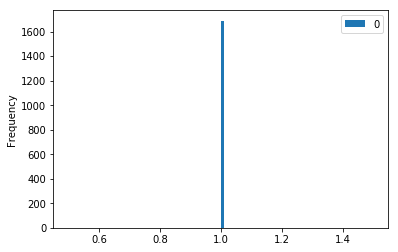

In [23]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba,1.0,sum
predict_label,,
0,169,169
1,1520,1520
sum,1689,1689


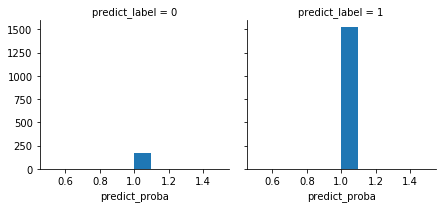

In [24]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1))
sel_data_stat

## K-fold

In [47]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
       # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='binary:logistic', scale_pos_weight=0.5))
])

filename = 'mot_class_label_proba_20190102.xlsx'
cal_kfold(title_content, label, pipeline, 'cor_result', filename, class_name_dict)

data_raw:  (5628, 5)
---- 1
0.9791203909373611
accuracy_score:  0.9174067495559503
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       177
           1       0.95      0.96      0.95       949

   micro avg       0.92      0.92      0.92      1126
   macro avg       0.85      0.83      0.84      1126
weighted avg       0.92      0.92      0.92      1126

confusion_matrix: 
[[125  52]
 [ 41 908]]
---- 2
0.9791203909373611
accuracy_score:  0.9236234458259325
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       203
           1       0.94      0.97      0.95       923

   micro avg       0.92      0.92      0.92      1126
   macro avg       0.88      0.85      0.86      1126
weighted avg       0.92      0.92      0.92      1126

confusion_matrix: 
[[148  55]
 [ 31 892]]
---- 3
0.9793425144380276
accuracy_score:  0.9218472468916519
              precision    recall  f1-score   support



In [ ]:
# import xlrd

# kfold_result = pd.DataFrame()

# currentPath  = 'circ_result_class/corpus/circ_class_label_proba_20181008.xlsx'
# excel = xlrd.open_workbook(currentPath)
# sheet_names = [sheet.name for sheet in excel.sheets()]
# for sheet_name in sheet_names:   
#     tmp_data = pd.read_excel(currentPath, sheet_name)     
#     kfold_result = pd.concat([kfold_result, tmp_data], axis = 0)

# kfold_result.index = range(kfold_result.shape[0])
# kfold_result.insert(0, '备注', '')
# print('总数：', kfold_result.shape)
# # kfold_result.head()

In [ ]:
# K_S_sel = kfold_result[(kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong')]
# K_S_else = kfold_result[~((kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong'))]
# print(kfold_result.shape)
# print(K_S_else.shape)
# print(K_S_sel.shape)
# K_S_sel.groupby(['R_W', 'predict_label'])['label'].count()

In [ ]:
# fea_filename = 'cbrc_result_class/result/20181008_circ_class_sel.xlsx'
# with pd.ExcelWriter(fea_filename) as writer:
#     for label in K_S_sel['predict_label'].unique():
#         tmp_data = K_S_sel[K_S_sel['predict_label'] == label]
#         N = tmp_data.shape[0]
#         tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
#     writer.save()
    
# fea_filename = 'cbrc_result_class/result/20181008_circ_class_else.xlsx'
# with pd.ExcelWriter(fea_filename) as writer:
#     for label in K_S_else['predict_label'].unique():
#         tmp_data = K_S_else[K_S_else['predict_label'] == label]
#         N = tmp_data.shape[0]
#         tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
#     writer.save()    

In [ ]:
# y_test = kfold_result['predict_label'].tolist()
# y_pred_class = kfold_result['label'].tolist()
# print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
# print(metrics.classification_report(y_test, y_pred_class))
# print('confusion_matrix: ')
# print( metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
# y_pred_prob = kfold_result['predict_proba'].tolist()

# sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
# sel_data_stat

## 保存模型

In [26]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
        # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

0.9818763326226013


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [27]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/mot_cor_0102.pkl.z")

['model/mot_cor_0102.pkl.z']